In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=64
N_FOLDS = 2

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


In [7]:
class SimpsonCNN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        # 224
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 110
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        # 54
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 26
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        # 12
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 5        
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, n_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data,gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop1(self.conv2(x))
        x = self.conv3(x)
        x = self.drop2(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 256)
        x = self.drop3(self.fc1(x))        
        x = self.fc2(x)        
        logits = self.out(x)
        return logits

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #opt = torch.optim.AdamW(model.parameters())
        opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=10, verbose=False)
        #scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        best_acc = 0.0
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_acc)
            #scheduler.step()
            
            if val_acc > best_acc:
                best_model_wghts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wghts, './model/simpson.mdl')
                best_acc = val_acc
                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [9]:
n_classes = len(np.unique(train_val_labels))
print(n_classes)
clf = SimpsonCNN(n_classes).to(DEVICE)
#clf = ConvModel(n_classes).to(DEVICE)
#print(clf)
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))


42
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
              ReLU-2         [-1, 32, 220, 220]               0
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 32, 108, 108]           9,248
              ReLU-5         [-1, 32, 108, 108]               0
         MaxPool2d-6           [-1, 32, 54, 54]               0
         Dropout2d-7           [-1, 32, 54, 54]               0
            Conv2d-8           [-1, 64, 52, 52]          18,496
              ReLU-9           [-1, 64, 52, 52]               0
        MaxPool2d-10           [-1, 64, 26, 26]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 24, 24]               0
        MaxPool2d-13          [-1, 128, 12, 12]               0
        Dropout2d-14          [-1, 1

In [10]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [11]:
submit = pd.DataFrame(columns=['Id'])

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]


FOLD 1
loss 3.3725733015160997


epoch:   3%|██▌                                                                         | 1/30 [01:10<34:12, 70.78s/it]


Epoch 001 train_loss: 3.3726     val_loss 2.7196 train_acc 0.1553 val_acc 0.2757
loss 2.5961823090658998


epoch:   7%|█████                                                                       | 2/30 [02:19<32:48, 70.30s/it]


Epoch 002 train_loss: 2.5962     val_loss 2.4528 train_acc 0.2961 val_acc 0.3375
loss 2.2364011749449544


epoch:  10%|███████▌                                                                    | 3/30 [03:28<31:26, 69.86s/it]


Epoch 003 train_loss: 2.2364     val_loss 2.1204 train_acc 0.3976 val_acc 0.4365
loss 1.9439422363098933


epoch:  13%|██████████▏                                                                 | 4/30 [04:37<30:07, 69.51s/it]


Epoch 004 train_loss: 1.9439     val_loss 1.9321 train_acc 0.4799 val_acc 0.4812
loss 1.692188134121958


epoch:  17%|████████████▋                                                               | 5/30 [05:46<28:55, 69.43s/it]


Epoch 005 train_loss: 1.6922     val_loss 1.7046 train_acc 0.5354 val_acc 0.5454
loss 1.4967889671056391


epoch:  20%|███████████████▏                                                            | 6/30 [06:55<27:40, 69.19s/it]


Epoch 006 train_loss: 1.4968     val_loss 1.5598 train_acc 0.5899 val_acc 0.5834
loss 1.2968645870908897


epoch:  23%|█████████████████▋                                                          | 7/30 [08:03<26:25, 68.95s/it]


Epoch 007 train_loss: 1.2969     val_loss 1.4752 train_acc 0.6410 val_acc 0.5995
loss 1.1547656567617646


epoch:  27%|████████████████████▎                                                       | 8/30 [09:12<25:14, 68.86s/it]


Epoch 008 train_loss: 1.1548     val_loss 1.2953 train_acc 0.6818 val_acc 0.6612
loss 1.0034447349665816


epoch:  30%|██████████████████████▊                                                     | 9/30 [10:21<24:07, 68.91s/it]


Epoch 009 train_loss: 1.0034     val_loss 1.2453 train_acc 0.7194 val_acc 0.6640
loss 0.8949459540193613


epoch:  33%|█████████████████████████                                                  | 10/30 [11:31<23:05, 69.29s/it]


Epoch 010 train_loss: 0.8949     val_loss 1.2111 train_acc 0.7448 val_acc 0.6852
loss 0.772905854320195


epoch:  37%|███████████████████████████▍                                               | 11/30 [12:42<22:03, 69.63s/it]


Epoch 011 train_loss: 0.7729     val_loss 1.2143 train_acc 0.7802 val_acc 0.6857
loss 0.6833332225205115


epoch:  40%|██████████████████████████████                                             | 12/30 [13:52<20:57, 69.84s/it]


Epoch 012 train_loss: 0.6833     val_loss 1.1338 train_acc 0.8043 val_acc 0.7166
loss 0.6079190949531771


epoch:  43%|████████████████████████████████▌                                          | 13/30 [15:01<19:46, 69.77s/it]


Epoch 013 train_loss: 0.6079     val_loss 1.0338 train_acc 0.8265 val_acc 0.7378
loss 0.5305360410055077


epoch:  47%|███████████████████████████████████                                        | 14/30 [16:11<18:34, 69.63s/it]


Epoch 014 train_loss: 0.5305     val_loss 1.0475 train_acc 0.8459 val_acc 0.7382
loss 0.4703621379169829


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [17:21<17:25, 69.70s/it]


Epoch 015 train_loss: 0.4704     val_loss 1.0481 train_acc 0.8627 val_acc 0.7325
loss 0.40436250802031126


epoch:  53%|████████████████████████████████████████                                   | 16/30 [18:30<16:14, 69.63s/it]


Epoch 016 train_loss: 0.4044     val_loss 1.0229 train_acc 0.8854 val_acc 0.7588
loss 0.36880936973831135


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [19:40<15:05, 69.62s/it]


Epoch 017 train_loss: 0.3688     val_loss 1.1174 train_acc 0.8874 val_acc 0.7392
loss 0.3136346954336596


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [20:49<13:52, 69.40s/it]


Epoch 018 train_loss: 0.3136     val_loss 1.1483 train_acc 0.9072 val_acc 0.7459
loss 0.28260538605104185


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [21:58<12:42, 69.33s/it]


Epoch 019 train_loss: 0.2826     val_loss 1.0541 train_acc 0.9157 val_acc 0.7666
loss 0.2583484413946698


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [23:08<11:34, 69.49s/it]


Epoch 020 train_loss: 0.2583     val_loss 1.0192 train_acc 0.9202 val_acc 0.7713
loss 0.20482485878024187


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [24:18<10:26, 69.63s/it]


Epoch 021 train_loss: 0.2048     val_loss 1.0453 train_acc 0.9337 val_acc 0.7832
loss 0.18687062037908364


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [25:28<09:18, 69.79s/it]


Epoch 022 train_loss: 0.1869     val_loss 1.0821 train_acc 0.9436 val_acc 0.7799
loss 0.17004988882644712


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [26:37<08:07, 69.70s/it]


Epoch 023 train_loss: 0.1700     val_loss 1.1524 train_acc 0.9490 val_acc 0.7692
loss 0.15698447449872036


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [27:51<07:05, 70.88s/it]


Epoch 024 train_loss: 0.1570     val_loss 1.1864 train_acc 0.9544 val_acc 0.7667
loss 0.12930542940055498


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [29:13<06:11, 74.21s/it]


Epoch 025 train_loss: 0.1293     val_loss 1.1568 train_acc 0.9601 val_acc 0.7818
loss 0.11086037351470603


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [30:29<04:59, 74.81s/it]


Epoch 026 train_loss: 0.1109     val_loss 1.1772 train_acc 0.9667 val_acc 0.7848
loss 0.09896050031639633


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [31:45<03:45, 75.25s/it]


Epoch 027 train_loss: 0.0990     val_loss 1.1807 train_acc 0.9705 val_acc 0.7855
loss 0.08989882884770264


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [33:10<02:36, 78.16s/it]


Epoch 028 train_loss: 0.0899     val_loss 1.2812 train_acc 0.9732 val_acc 0.7846
loss 0.09328014859276912


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [34:32<01:19, 79.34s/it]


Epoch 029 train_loss: 0.0933     val_loss 1.2210 train_acc 0.9707 val_acc 0.7919
loss 0.08459292670941153


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [35:54<00:00, 71.83s/it]


Epoch 030 train_loss: 0.0846     val_loss 1.2486 train_acc 0.9739 val_acc 0.7895


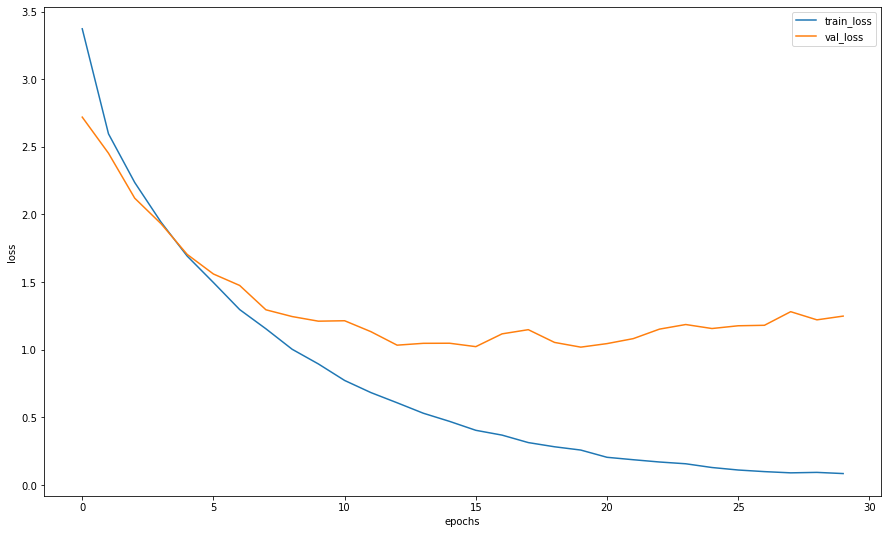

In [12]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = SimpsonCNN(n_classes).to(DEVICE)
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds
    break

In [13]:
torch.cuda.empty_cache()

###  Submission

In [14]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('submission_custom_kfold_sgd-3_lrp.csv', index=False)
submit.head()

,Id,fold_1,Expected
0,img0.jpg,nelson_muntz,img0.jpg
1,img1.jpg,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,img10.jpg
3,img100.jpg,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon
